In [1]:
!pip install casadi
from IPython.display import clear_output
import os

import numpy as np
import casadi
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation

os.makedirs('images',exist_ok=True)
if os.name == 'nt':
    plt.rcParams['font.family'] = 'MS Gothic'
elif os.name == 'posix':
    !pip install japanize-matplotlib


clear_output()

In [2]:
m = 1
# J = 2.5 * 1e-4
J = 1e-1
l = 0.086
g = 9.81

nx = 6 #状態変数の次元
nu = 2 #制御変数の次元

# 後退ホライズン等
T = 1
K = 20
dt = T/K

#コスト行列
Q = casadi.diag([10,10,10,10,10,10])
Q_f = casadi.diag([10,10,10,10,10,10])
R = casadi.diag([0.1,0.1])

# 制約条件
x_lb = [-np.inf,-np.inf,-np.pi/2,-np.inf,-np.inf,-np.inf]
x_ub = [np.inf,np.inf,np.pi/2,np.inf,np.inf,np.inf]
u_lb = [0,0]
u_ub = [10,10]

#目標値
x_ref = casadi.DM([3,3,0,0,0,0])
u_ref = casadi.DM([m*g/2,m*g/2])

total = nx*(K+1) + nu*K

In [3]:
def make_f():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)

    x = states[0]
    y = states[1]
    theta = states[2]
    x_dot = states[3]
    y_dot = states[4]
    theta_dot = states[5]
    f1 = ctrls[0]
    f2 = ctrls[1]

    x_ddot = -g*theta
    y_ddot = (f1+f2)/m -g
    theta_ddot = (f1-f2)*l/J

    states_dot = casadi.vertcat(x_dot,y_dot,theta_dot,x_ddot,y_ddot,theta_ddot)

    f = casadi.Function("f",[states,ctrls],[states_dot],['x','u'],['x_dot'])
    return f

def make_RK4():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)

    f = make_f()

    r1 = f(x=states,u=ctrls)["x_dot"]
    r2 = f(x=states+dt*r1/2,u=ctrls)["x_dot"]
    r3 = f(x=states+dt*r2/2,u=ctrls)["x_dot"]
    r4 = f(x=states+dt*r3,u=ctrls)["x_dot"]

    states_next = states + dt*(r1+2*r2+2*r3+r4)/6

    RK4 = casadi.Function("RK4",[states,ctrls],[states_next],["x","u"],["x_next"])
    return RK4

def make_integrator():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)

    f = make_f()
    ode = f(x=states, u=ctrls)["x_dot"]

    dae = {"x":states,"p":ctrls,"ode":ode}

    I = casadi.integrator("I","cvodes",dae,0,dt)
    return I

def compute_stage_cost(x,u):
    x_diff = x - x_ref
    u_diff = u - u_ref
    cost = (casadi.dot(Q@x_diff,x_diff) + casadi.dot(R@u_diff,u_diff)) / 2
    return cost

def compute_final_cost(x):
    x_diff = x - x_ref
    cost = casadi.dot(Q_f@x_diff,x_diff) / 2
    return cost

In [97]:
def make_qp():
    RK4 = make_RK4()

    U = [casadi.SX.sym(f"u_{i}",nu) for i in range(K)]
    X = [casadi.SX.sym(f"x_{i}",nx) for i in range(K+1)]
    G = []

    J = 0

    for k in range(K):
        J += compute_stage_cost(X[k],U[k]) * dt
        eq = X[k+1] - RK4(x=X[k],u=U[k])["x_next"]
        G.append(eq)
    J += compute_final_cost(X[-1])

    qp = {"x":casadi.vertcat(*X,*U),"f":J,"g":casadi.vertcat(*G)}
    S = casadi.qpsol("S","osqp",qp)
    return S

def make_hpipm():
    RK4 = make_RK4()
    f = make_f()

    U = [casadi.SX.sym(f"u_{i}",nu) for i in range(K)]
    X = [casadi.SX.sym(f"x_{i}",nx) for i in range(K+1)]
    G = []

    J = 0

    for k in range(K):
        J += compute_stage_cost(X[k],U[k]) * dt
        # eq = X[k+1] - RK4(x=X[k],u=U[k])["x_next"]
        eq = X[k+1] - X[k] - dt*f(x=X[k],u=U[k])["x_dot"]
        G.append(eq)
    J += compute_final_cost(X[-1])

    x = []
    for k in range(K+1):
        x.append(X[k])
        x.append(U[k]) if k < K else None

    qp = {"x":casadi.vertcat(*x),"f":J,"g":casadi.vertcat(*G)}
    # option = {
    #     "N":K,
    #     "nx":[nx]*(K+1),
    #     "nu":[nu]*(K+1),
    #     "ng":[0]*(K+1)
    # }
    S = casadi.qpsol("S","hpipm",qp)
    return S

In [98]:
def compute_optimal_control(S,x_init,x0):
    x_init = x_init.full().ravel().tolist()
    
    lbx = x_init + x_lb*K + u_lb*K
    ubx = x_init + x_ub*K + u_ub*K
    lbg = [0]*nx*K
    ubg = [0]*nx*K

    res = S(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg,x0=x0)
    
    offset = nx*(K+1)
    x0 = res["x"]
    u_opt = x0[offset:offset+nu]
    return u_opt, x0

In [99]:
S_qp = make_qp()
S_hpipm = make_hpipm()

nx,nu,ng[8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6][0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0][0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
nus[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0]
nu22:20
0
625
166
3892


In [60]:
I = make_integrator()
x_init = casadi.DM([0,0,0,0,0,0])
x0 = [x_init]
x_tmp = x_init
for i in range(K):
    x_tmp = I(x0=x_tmp)["xf"]
    x0.append(x_tmp)
u0 = casadi.DM.zeros(nu*K)
x0 = casadi.vertcat(*x0,u0)

S_hpipm(x0=x0,lbg=[0]*nx*K,ubg=[0]*nx*K)

HPIPM finished after 1 iterations.
return status: 3
HPIPM residuals: nan, nan, nan, nan


Function S_qpsol (0x17e4a63dda0)
Input 0 (h): sparse: 166-by-166, 166 nnz
 (0, 0) -> 0.5
 (1, 1) -> 0.5
 (2, 2) -> 0.5
 (3, 3) -> 0.5
 (4, 4) -> 0.5
 (5, 5) -> 0.5
 (6, 6) -> 0.005
 (7, 7) -> 0.005
 (8, 8) -> 0.5
 (9, 9) -> 0.5
 (10, 10) -> 0.5
 (11, 11) -> 0.5
 (12, 12) -> 0.5
 (13, 13) -> 0.5
 (14, 14) -> 0.005
 (15, 15) -> 0.005
 (16, 16) -> 0.5
 (17, 17) -> 0.5
 (18, 18) -> 0.5
 (19, 19) -> 0.5
 (20, 20) -> 0.5
 (21, 21) -> 0.5
 (22, 22) -> 0.005
 (23, 23) -> 0.005
 (24, 24) -> 0.5
 (25, 25) -> 0.5
 (26, 26) -> 0.5
 (27, 27) -> 0.5
 (28, 28) -> 0.5
 (29, 29) -> 0.5
 (30, 30) -> 0.005
 (31, 31) -> 0.005
 (32, 32) -> 0.5
 (33, 33) -> 0.5
 (34, 34) -> 0.5
 (35, 35) -> 0.5
 (36, 36) -> 0.5
 (37, 37) -> 0.5
 (38, 38) -> 0.005
 (39, 39) -> 0.005
 (40, 40) -> 0.5
 (41, 41) -> 0.5
 (42, 42) -> 0.5
 (43, 43) -> 0.5
 (44, 44) -> 0.5
 (45, 45) -> 0.5
 (46, 46) -> 0.005
 (47, 47) -> 0.005
 (48, 48) -> 0.5
 (49, 49) -> 0.5
 (50, 50) -> 0.5
 (51, 51) -> 0.5
 (52, 52) -> 0.5
 (53, 53) -> 0.5
 (54

RuntimeError: Error in Function::call for 'S' [MXFunction] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'S' [MXFunction] at .../casadi/core/function.cpp:330:
Error in Function::operator() for 'S_qpsol' [HpipmInterface] at .../casadi/core/function.cpp:1482:
.../casadi/core/conic.cpp:537: conic process failed. Set 'error_on_fail' option to false to ignore this error.

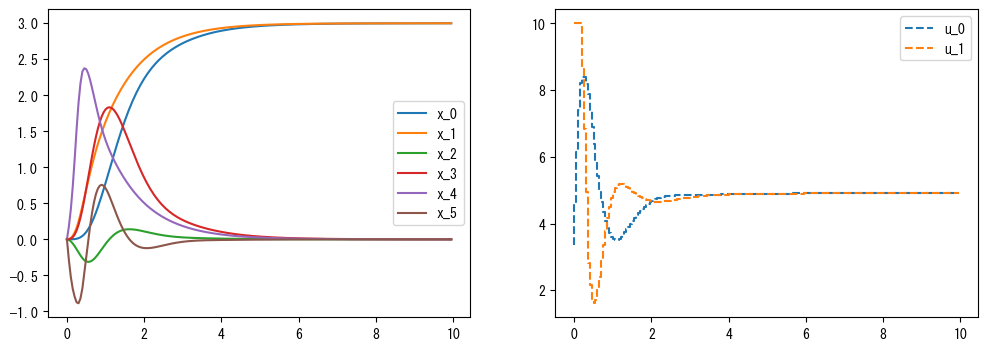

In [55]:
t_span = [0,10]
t_eval = np.arange(*t_span,dt)
I = make_integrator()

x_init = casadi.DM([0,0,0,0,0,0]) # 初期値
x0 = casadi.DM.zeros(total)

X = [x_init]
U = []
x_current = x_init
for t in t_eval:
    u_opt,x0 = compute_optimal_control(S_qp,x_current,x0)
    x_current = I(x0=x_current,p=u_opt)["xf"]
    X.append(x_current)
    U.append(u_opt)

X.pop()
X = np.array(X).reshape(t_eval.size,nx)
U = np.array(U).reshape(t_eval.size,nu)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
for k in range(nx):
    plt.plot(t_eval,X[:,k],label=f"x_{k}")
plt.legend()

plt.subplot(1,2,2)
for k in range(nu):
    plt.step(t_eval,U[:,k],linestyle="--",label=f"u_{k}")
plt.legend()

plt.show()

In [ ]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
frames = np.arange(0,t_eval.size)
fps = 1 / dt

def update_figure(i):
    x_lim_min = -1
    x_lim_max = 4
    y_lim_min = -1
    y_lim_max = 4
    u_scale = 40

    ax.cla()
    ax.set_xlim(x_lim_min, x_lim_max)
    ax.set_ylim(y_lim_min, y_lim_max)
    ax.set_aspect("equal")

    x,y,theta,_,_,_ = X[i]
    f1,f2 = U[i]

    center = np.array([x,y])
    left = center - l*np.array([np.cos(theta),np.sin(theta)])
    right = center + l*np.array([np.cos(theta),np.sin(theta)])
    points = np.stack([left,right],axis=0)
    ref = x_ref[:2].full().ravel()
    
    left_f = f2*np.array([-np.sin(theta),np.cos(theta)])
    right_f = f1*np.array([-np.sin(theta),np.cos(theta)])

    ax.scatter(*center,color="blue",s=5)
    ax.scatter(*ref,color="red",s=5,marker="*")
    ax.plot(*points.T, color='blue', lw=1)

    ax.arrow(*left,*left_f/u_scale,width=0.01,head_width=0.03,head_length=0.06,length_includes_head=False,color="green",zorder=3)
    ax.arrow(*right,*right_f/u_scale,width=0.01,head_width=0.03,head_length=0.06,length_includes_head=False,color="green",zorder=3)

ani = FuncAnimation(fig, update_figure, frames=frames)
ani.save("images/chap7_planer_quadrotor.gif",writer="pillow",fps=fps)